### **StanfordCar classifier**

## Esame: Deep Learning and Generative Models

Alberto Coffrini - LM Scienze Informatiche  - UniPR


In [10]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import time
import os
import PIL.Image as Image
from IPython.display import display


cuda:0
Tesla P100-PCIE-16GB


In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
Tesla P100-PCIE-16GB


## MEAN E STD



In [3]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder

dataset_dir = "/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/"

dataset_for_stats = ImageFolder(root=dataset_dir + "train", transform=transform_for_stats)

# DataLoader
data_loader_for_stats = torch.utils.data.DataLoader(dataset_for_stats, batch_size=32, shuffle=False, num_workers=2)


# trasforms for mean std
transform_for_stats = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor()
])

# mean and std
mean = 0.0
std = 0.0
total_samples = 0

for images, _ in data_loader_for_stats:
    batch_size = images.size(0)
    images = images.view(batch_size, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_samples += batch_size

mean /= total_samples
std /= total_samples

print("Mean:", mean)
print("Std:", std)

KeyboardInterrupt: 

## DATA

In [13]:
# dataset URL on Kaggle.
# OPTION TODO: CHANGE IT ON OTHER DEVICE
dataset_dir = "/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/"

# transforms 
transformation_train = transforms.Compose(
                                [transforms.Resize((300, 300)),
                                 transforms.RandomRotation(15),
                                 transforms.RandomCrop((250, 250)),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.4708, 0.4602, 0.4550), (0.2612, 0.2603, 0.2653))])

transformation_train2 = transforms.Compose(
                                [transforms.Resize((300, 300)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ColorJitter(brightness=0.5, contrast=1, saturation=0.1, hue=0.5),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.4708, 0.4602, 0.4550), (0.2612, 0.2603, 0.2653))])

transformation_test = transforms.Compose([transforms.Resize((300, 300)),
                                transforms.ToTensor(),
                                 transforms.Normalize((0.4708, 0.4602, 0.4550), (0.2612, 0.2603, 0.2653))])


# dataset for TRAINING and TESTING phase
dataset_train = torchvision.datasets.ImageFolder(root=dataset_dir+"train", transform = transformation_train)
dataset_train2 = torchvision.datasets.ImageFolder(root=dataset_dir+"train", transform = transformation_train2)

dataset_test = torchvision.datasets.ImageFolder(root=dataset_dir+"test", transform = transformation_test)

trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=True, num_workers=2)
trainloader2 = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(dataset_test, batch_size=32, shuffle=False, num_workers=2)


## TRAINING


In [14]:

def train_model(model, criterion, optimizer, scheduler, n_epochs = 5):
    #keep in memory data analysis
    losses = []
    accuracies = []
    test_accuracies = []
    
    # model in train mode 
    model.train()
    
    for epoch in range(n_epochs):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        if epoch % 2 == 0:
            trainloader_diverso = trainloader
            print("trainloader1")
        else:
            trainloader_diverso = trainloader2
            print("trainloader2")
        
        for i, data in enumerate(trainloader_diverso, 0):

            # obtain the inputs
            inputs, labels = data
            # assign inputs to cuda
            inputs = inputs.to(device)
            labels = labels.to(device)
            # optimizer
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        # data each epoch
        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(trainloader_diverso)
        epoch_acc = 100/32*running_correct/len(trainloader_diverso)
        print("Epoch number %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc)) #printing on terminal
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        # model in eval mode
        model.eval()
        test_acc = eval_model(model)
        test_accuracies.append(test_acc)
        
        # model in train mode
        model.train()
        scheduler.step(test_acc)
        since = time.time()
        
    print('Finished Training') #ending of training phase
    
    return model, losses, accuracies, test_accuracies

    

### EVALUATE


In [15]:
def eval_model(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            images, labels = data
           
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    print('Accuracy on the test images: %d %%' % (test_acc))
    return test_acc

## MODELS


In [16]:
# pytorch model here
# OPTION TODO: CHANGE IT FOR OTHER MODELS

#model_ft = models.resnet18(pretrained=True)
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# last fc layer replaced qwith an untrained one
model_ft.fc = nn.Linear(num_ftrs, 196) #(with grads)
model_ft = model_ft.to(device)

#  CrossEntropyLoss and stochastic gradient descent
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

## TRAIN AND SAVE

In [17]:
print('Training')

# TRAIN
model_ft, training_losses, training_accs, test_accs = train_model(model_ft, criterion, optimizer, lrscheduler, n_epochs=10)

#save model on output file
#OPTION TODO: change name for different model
torch.save(model_ft.state_dict(), "./trainedModelFinalRN18Aug12.pt")

Training
trainloader1


KeyboardInterrupt: 

In [ ]:
torch.save(model_ft.state_dict(), "./trainedModelFinalRN18Aug.pt")

## PLOT GRAPHS

Text(0.5, 1.0, 'Test acc')

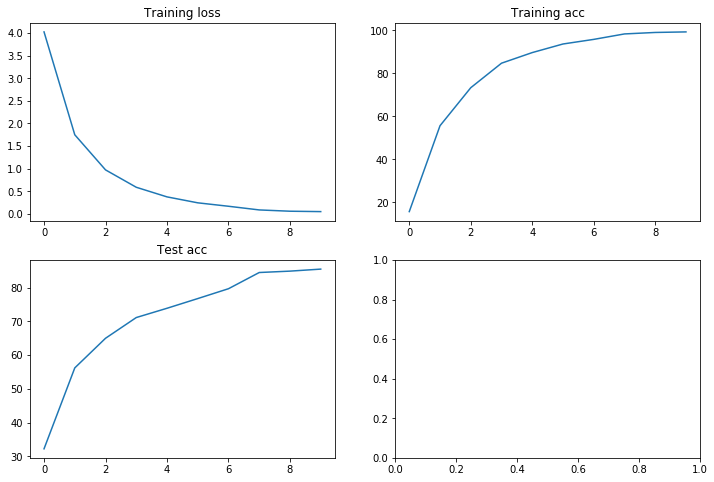

In [27]:
# Plotting

f, axarr = plt.subplots(2,2, figsize = (12, 8))

axarr[0, 0].plot(training_losses)
axarr[0, 0].set_title("Training loss")

axarr[0, 1].plot(training_accs)
axarr[0, 1].set_title("Training acc")

axarr[1, 0].plot(test_accs)
axarr[1, 0].set_title("Test acc")

### Evaluate the model on single images

In [ ]:
# tie the class indices to their names

def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
classes, c_to_idx = find_classes(dataset_dir+"train")

## UPLOAD THE MODEL TRAINED BEFORE

In [ ]:
modelUp = models.resnet34(pretrained=True)
num_ftrs = modelUp.fc.in_features

# replace the last fc layer with an untrained one (requires grad by default)
modelUp.fc = nn.Linear(num_ftrs, 196)
modelUp = modelUp.to(device)

modelUp.load_state_dict(torch.load('/kaggle/input/resnet37/trainedModelFinal.pt'))


In [ ]:

# test the model on random images


# switch the model to evaluation mode to make dropout and batch norm work in eval mode
modelUp.eval()

# transforms for the input image
loader = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
image = Image.open(dataset_dir+"test/BMW 1 Series Convertible 2012/01795.jpg")
image = loader(image).float()
image = torch.autograd.Variable(image, requires_grad=True)
image = image.unsqueeze(0)
image = image.cuda()
output = modelUp(image)
conf, predicted = torch.max(output.data, 1)

# get the class name of the prediction
display(Image.open(dataset_dir+"test/BMW 1 Series Convertible 2012/01795.jpg"))
print(classes[predicted.item()], "confidence: ", conf.item())
eval_model(modelUp)

### MATRICE DI CONFUSIONE - HEATMAP 


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:

# n° classes
nb_classes = 196

confusion_matrix = np.zeros((nb_classes, nb_classes))

plt.figure(figsize=(20, 20))

# confusion matrix 
with torch.no_grad():
    for inputs, classes in testloader:
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = modelUp(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

# dataframe with confusion matrix
df_cm = pd.DataFrame(confusion_matrix)

# heatmap
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")

# X e Y axis
plt.yticks(rotation=0, fontsize=15)
plt.xticks(rotation=45, fontsize=15)

plt.ylabel('True label')
plt.xlabel('Predicted label')

# saving heatmap
plt.savefig("heatmapRN37.png")

plt.show()
